In [40]:
import os
import glob
import re 
from xml.dom import minidom
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# read the data

In [2]:
os.system('tar -xvf  ./data/NLMCXR_reports.tgz -C ./data/')

512

In [3]:
allFiles = glob.glob(f'./data/**/*.xml', recursive=True)

In [4]:
len(allFiles)

3955

# Convert XML to csv

In [5]:
def getfilename(xml_file):
    x = re.search("[ \w-]+?(?=\.)", xml_file)
    return x.group()

def get_report(xml_file):
    #get radiology report text
    data = {}
    mydoc = minidom.parse(xml_file)
    elements = mydoc.getElementsByTagName('AbstractText')
    for element in elements:
        txt = np.nan
        if element.firstChild != None:
            if element.firstChild.data == "None.":
                txt = np.nan
            else:
                txt = element.firstChild.data
        data[element.attributes['Label'].value] = txt
        
    return data

def get_labels(xml_file):
    data = {}
    mydoc = minidom.parse(xml_file)
    elements = mydoc.getElementsByTagName('major')
    txt = []
    for element in elements:
        if element.firstChild != None:
            txt.append(element.firstChild.data)
    if len(txt) == 0:
        txt = np.nan
    data['expert_labels'] = txt
    
    elements = mydoc.getElementsByTagName('automatic')
    txt = []
    for element in elements:
        if element.firstChild != None:
            txt.append(element.firstChild.data)
    if len(txt) == 0:
        txt = np.nan
    data['manual_labels'] = txt
    
    return data

def convert_xml2csv(allFiles):
    columns = ["fileNo", "COMPARISON", "INDICATION", "FINDINGS", "IMPRESSION", "expert_labels", "manual_labels"]
    xml_df = pd.DataFrame(columns = columns)
    for xml_file in tqdm(allFiles):
#         print(xml_file)
        row = {}
        row['fileNo'] = getfilename(xml_file)

        reportDic = get_report(xml_file)
        labelsDic = get_labels(xml_file)

        row = {**row ,**reportDic, **labelsDic}
        xml_df = xml_df.append(row,ignore_index=True)
    return xml_df

xml_df = convert_xml2csv(allFiles)
xml_df.head()

100%|██████████| 3955/3955 [00:35<00:00, 110.74it/s]


,fileNo,COMPARISON,INDICATION,FINDINGS,IMPRESSION,expert_labels,manual_labels
0,881,None available.,XXXX-year-old XXXX with dyspnea.,The lungs are without focal air space opacity....,No acute cardiopulmonary abnormality.,[normal],NaN
1,1734,NaN,Back pain,Heart size and mediastinal contour are normal....,No acute cardiopulmonary process.,[normal],NaN
2,306,NaN,NaN,The lungs are clear. Heart size is normal. No ...,Clear lungs. No acute cardiopulmonary abnormal...,[normal],NaN
3,3188,"Chest x-XXXX, XXXX, XXXX.",This is a XXXX-year-old male patient with vomi...,NaN,The cardiac silhouette appears be at upper lim...,"[Cardiac Shadow/enlarged/borderline, Mediastin...",NaN
4,1951,NaN,NaN,Cardiomediastinal silhouette is normal. Pulmon...,No acute cardiopulmonary disease.,[normal],NaN


# Some stats


In [6]:
print("Total No. of reports: ", len(xml_df) )

Total No. of reports:  3955


In [7]:
xml_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3955 entries, 0 to 3954
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   fileNo         3955 non-null   object
 1   COMPARISON     2507 non-null   object
 2   INDICATION     3865 non-null   object
 3   FINDINGS       3425 non-null   object
 4   IMPRESSION     3921 non-null   object
 5   expert_labels  3955 non-null   object
 6   manual_labels  2182 non-null   object
dtypes: object(7)
memory usage: 216.4+ KB


In [8]:
xml_df['expert_labels']

0                                                [normal]
1                                                [normal]
2                                                [normal]
3       [Cardiac Shadow/enlarged/borderline, Mediastin...
4                                                [normal]
                              ...                        
3950    [Pulmonary Congestion, Pulmonary Edema/interst...
3951    [Opacity/lung/base/bilateral, Pulmonary Atelec...
3952                                             [normal]
3953    [Lung/hyperdistention, Pulmonary Emphysema, Pe...
3954    [Aorta/tortuous/mild, Lung/hyperdistention, Op...
Name: expert_labels, Length: 3955, dtype: object

# Add a column for Noraml or not normal expert labels (NormalLabel)

In [9]:
NaN = np.nan
xml_df['NormalLabel'] = NaN

In [10]:
xml_df.head()

,fileNo,COMPARISON,INDICATION,FINDINGS,IMPRESSION,expert_labels,manual_labels,NormalLabel
0,881,None available.,XXXX-year-old XXXX with dyspnea.,The lungs are without focal air space opacity....,No acute cardiopulmonary abnormality.,[normal],NaN,NaN
1,1734,NaN,Back pain,Heart size and mediastinal contour are normal....,No acute cardiopulmonary process.,[normal],NaN,NaN
2,306,NaN,NaN,The lungs are clear. Heart size is normal. No ...,Clear lungs. No acute cardiopulmonary abnormal...,[normal],NaN,NaN
3,3188,"Chest x-XXXX, XXXX, XXXX.",This is a XXXX-year-old male patient with vomi...,NaN,The cardiac silhouette appears be at upper lim...,"[Cardiac Shadow/enlarged/borderline, Mediastin...",NaN,NaN
4,1951,NaN,NaN,Cardiomediastinal silhouette is normal. Pulmon...,No acute cardiopulmonary disease.,[normal],NaN,NaN


In [11]:
xml_df['NormalLabel'] = xml_df.apply(lambda row: 1 if row['expert_labels'][0] == 'normal'\
                      else 0 , axis=1)
xml_df.head()

,fileNo,COMPARISON,INDICATION,FINDINGS,IMPRESSION,expert_labels,manual_labels,NormalLabel
0,881,None available.,XXXX-year-old XXXX with dyspnea.,The lungs are without focal air space opacity....,No acute cardiopulmonary abnormality.,[normal],NaN,1
1,1734,NaN,Back pain,Heart size and mediastinal contour are normal....,No acute cardiopulmonary process.,[normal],NaN,1
2,306,NaN,NaN,The lungs are clear. Heart size is normal. No ...,Clear lungs. No acute cardiopulmonary abnormal...,[normal],NaN,1
3,3188,"Chest x-XXXX, XXXX, XXXX.",This is a XXXX-year-old male patient with vomi...,NaN,The cardiac silhouette appears be at upper lim...,"[Cardiac Shadow/enlarged/borderline, Mediastin...",NaN,0
4,1951,NaN,NaN,Cardiomediastinal silhouette is normal. Pulmon...,No acute cardiopulmonary disease.,[normal],NaN,1


In [12]:
xml_df['NormalLabel'].value_counts()

0    2564
1    1391
Name: NormalLabel, dtype: int64

# Export the csv file

In [13]:
xml_df.to_csv('OpenI.csv', index=False)

In [14]:
################# remove the unziped data #################
os.system('rm -rf ./data/OpenI/ecgen-radiology')

0

# Distributions

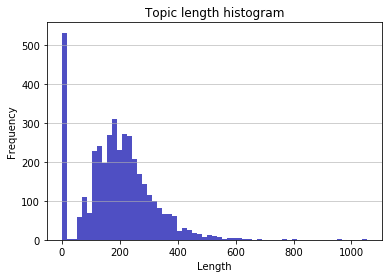

In [29]:
##############Finding#############
finding_lens = []
for finding in xml_df['FINDINGS']:
    length = 0
    if finding is not np.nan:
#         print(finding)
        length = len(finding)
    finding_lens.append(length)

n, bins, patches = plt.hist(x=finding_lens, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title('FINDINGS length histogram')

maxfreq = n.max()
plt.grid(axis='y', alpha=0.75)

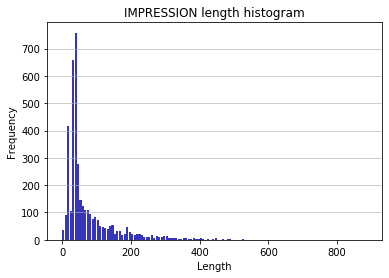

In [36]:
##############Finding#############
impression_lens = []
for impression in xml_df['IMPRESSION']:
    length = 0
    if impression is not np.nan:
        length = len(impression)
    impression_lens.append(length)

n, bins, patches = plt.hist(x=impression_lens, bins='auto', color='#0504aa',
                            alpha=0.8, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title('IMPRESSION length histogram')

maxfreq = n.max()
plt.grid(axis='y', alpha=0.75)

In [49]:
expert_labels = []
for labels in xml_df['expert_labels']:
    for label in labels:
        expert_labels.append(label)

print("No. of Unique expert labels:", len(letter_counts))
label_counts = Counter(expert_labels)




No. of Unique expert labels: 1719


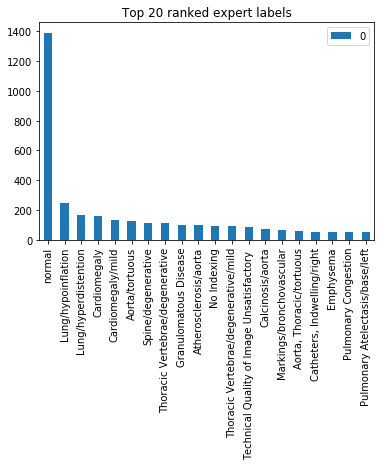

In [71]:
from collections import OrderedDict
from itertools import islice

sorted_label_counts = OrderedDict(sorted(label_counts.items(), key=lambda x: x[1], reverse=True))
# print(sorted_label_counts)

sliced = islice(sorted_label_counts.items(), 20)  # o.iteritems() is o.items() in Python 3
sliced_o = OrderedDict(sliced)

df = pandas.DataFrame.from_dict(sliced_o, orient='index')
df.plot(kind='bar', title = "Top 20 ranked expert labels")